In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

In [2]:
#url = 'https://github.com/zozunin/project/blob/main/HW_2_v13.xls?raw=true'

filepath = 'HW_2_v13.xls'
cols = ['Возраст (лет)', 'Количество иждивенцев', 'Доход (руб./мес.)',
        'Срок проживания в регионе (лет)','Оценка автомобиля заемщика (USD)',
        'Размер кредита(тыс. руб.)']
X = pd.read_excel(filepath, header=None)
X.columns = cols
X.head(10)

,Возраст (лет),Количество иждивенцев,Доход (руб./мес.),Срок проживания в регионе (лет),Оценка автомобиля заемщика (USD),Размер кредита(тыс. руб.)
0,37,1,7400,9,7000,70000
1,45,3,33100,12,34000,337000
2,32,1,18700,5,17000,176000
3,39,2,29100,9,29000,289000
4,33,1,11400,6,10000,104000
5,28,1,20100,2,18000,184000
6,47,2,4400,15,6000,55000
7,36,2,30500,7,30000,299000
8,45,3,32300,12,33000,330000
9,39,2,25900,9,26000,258000


## Изучение данных

Рассмотрим первоначальные данные

In [3]:
print("Количество строк и признаков:", X.shape)

Количество строк и признаков: (50, 6)


In [4]:
X.describe()

,Возраст (лет),Количество иждивенцев,Доход (руб./мес.),Срок проживания в регионе (лет),Оценка автомобиля заемщика (USD),Размер кредита(тыс. руб.)
count,50.000000,50.000000,50.0000,50.000000,50.00,50.000000
mean,39.960000,2.020000,20052.0000,10.100000,20060.00,200100.000000
std,8.025368,1.020004,9897.8299,4.900021,10027.33,99924.308088
min,19.000000,0.000000,2000.0000,0.000000,0.00,3000.000000
25%,35.250000,1.000000,10950.0000,7.000000,11000.00,106750.000000
50%,40.000000,2.000000,19800.0000,10.000000,19500.00,193500.000000
75%,45.000000,2.750000,28925.0000,13.000000,28750.00,286000.000000
max,59.000000,4.000000,38600.0000,22.000000,38000.00,382000.000000


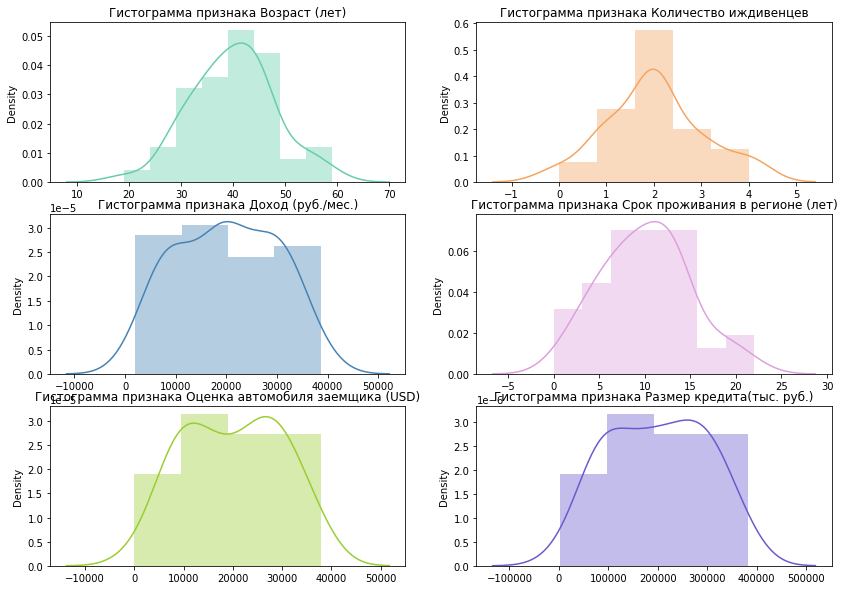

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
colors = ["mediumaquamarine", "sandybrown", "steelblue", "plum", "yellowgreen", "slateblue"]
row, col = 0, 0
for i in range (len(colors)):
    ax = sns.distplot(ax = axes[row,col], a = X[X.columns[i]], color=colors[i])
    ax.set(title = "Гистограмма признака {}".format(X.columns[i]), xlabel = None)
    col += 1
    if col == 2:
        row += 1
        col = 0
    

Симметрично представлено только распределение признака "Количество иждивенцев", в остальных случаях гистограммы скошены. Однако из-за объема исходных данных (50 строк) мы можем пренебречь приведением к нормальному распределению.

## PCA

Проведем центрирование и нормализацию данных.

In [3]:
Z = X - X.mean()
norms = [np.linalg.norm(Z[i]) for i in Z.columns]
Z = Z/norms

Проверим, равна ли норма каждого признака после центрирования и нормализации единице:
(при условии погрешности работы с числами типа float)

In [7]:
def round_variables(x): #округление с учетом погрешности
        if 1 - x < 1e-6:
            return 1.0
        else: 
            return x

In [8]:
for column_name in Z.columns:
    print(round_variables(np.linalg.norm(Z[column_name])) == 1.0)

True
True
True
True
True
True


Как видно, равенство выполнено для всех признаков, следовательно, центрирование и нормализация выполнены верно.

С помощью библиотеки numpy найдем сингулярное разложение нормализованной матрицы Z.

In [8]:
U, S, VT = np.linalg.svd(Z)

Докажем, что при выбранной нормировке коэффициенты разложения столбцов матрицы Z по скрытым факторам являются корреляциями этих столбцов и скрытых факторов. Для этого решим СЛУ относительно каждого столбца матрицы Z, затем найдем корреляции столбцов U со столбцами Z и сравним с коэффициентами, полученными при решении СЛУ:

In [9]:
no_of_errors = 0
coeffs = [] #коэффициенты разложения каждого столбца Z по скрытым факторам
for column_name in Z.columns:
    coeffs.append(np.linalg.solve(U, Z[column_name]))
    for column_no in range(U.shape[1]):
        if round(np.correlate(U[:,column_no], Z[column_name])[0],8) != round(coeffs[-1][column_no],8):
            no_of_errors += 1 #засчитываем одну ошибку, если коэффициент разложения не равен коэф-ту корреляции
            
print('Количество несовпадений: {}'.format(no_of_errors))

Количество несовпадений: 0


Как видно, все коэффициенты разложения столбцов Z по столбцам U совпали с корреляциями, ч.т.д

Чтобы понять, сколько главных факторов будет достаточно, найдем вклад в вариацию, а также высчитаем кумулятивный вклад совокупностей факторов. Результаты приведены в таблице ниже.

In [11]:
ev_table = pd.DataFrame()

pc_num = [i+1 for i in range(len(S))]
ev_table[0] = pc_num
ev_table[1] = S.round(2)
qrS = S ** 2
ev_table[2] = qrS.round(2)
percentvar = [round(i/6.0*100,2) for i in S**2]
ev_table[3] = percentvar
ev_table[4] = np.cumsum(percentvar)

ev_table.columns=['Главные факторы', 'Сингулярные значения',
                                'Собственные значения', 'Вклад в вариацию(%)',
                                'Кумулятивный вклад в вариацию(%)']
ev_table

,Главные факторы,Сингулярные значения,Собственные значения,Вклад в вариацию(%),Кумулятивный вклад в вариацию(%)
0,1,1.84,3.38,56.39,56.39
1,2,1.60,2.55,42.51,98.90
2,3,0.24,0.06,0.99,99.89
3,4,0.07,0.01,0.09,99.98
4,5,0.03,0.00,0.02,100.00
5,6,0.01,0.00,0.00,100.00


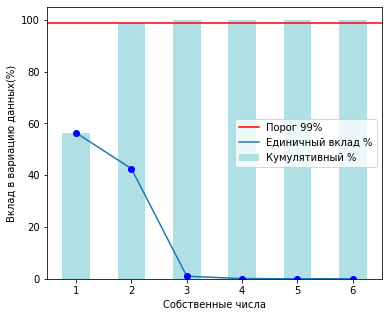

In [12]:
plt.figure(figsize=(6,5))
plt.bar(pc_num, np.cumsum(percentvar), color='powderblue', width=0.5,
       label='Кумулятивный %')
plt.axhline(y=99, color='r', linestyle='-', label='Порог 99%')
plt.plot(pc_num, percentvar, label='Единичный вклад %')
plt.plot(pc_num, percentvar, 'bo')
plt.xlabel('Собственные числа')
plt.ylabel('Вклад в вариацию данных(%)')
plt.legend(loc='center right')
plt.show()

Видно, что основной вклад вносят два первых главных фактора, их кумулятивный вклад приблизительно равен порогу в 99%, поэтому есть смысл использовать только первые два фактора. Таким образом, k=2 и матрица Z будет аппроксимироваться матрицей Zk.

Высчитаем ошибки аппроксимации в нормах Евклидовой и Фробениуса

In [13]:
print("Два главных фактора вносят {}% в вариацию данных".format(sum(percentvar[:2])))

#||A −Ak||2 = σk+1
print("Ошибка аппроксимации в евклидовой матричной норме, где k=2: ", round(S[2], 2))
 
# ||A −Ak||2F = σ2k+1 + ... + σ2p
fr_error = round(sum(S[2:]**2),2)
print("Ошибка аппроксимации в норме Фробениуса, где k=2: ", fr_error)

rel_fr_error = round(sum(S[2:]**2)/sum(S**2)*100, 2)

print("Относительная ошибка аппроксимации в норме Фробениуса, где k=2: {}%".format(rel_fr_error))

Два главных фактора вносят 98.9% в вариацию данных
Ошибка аппроксимации в евклидовой матричной норме, где k=2:  0.24
Ошибка аппроксимации в норме Фробениуса, где k=2:  0.07
Относительная ошибка аппроксимации в норме Фробениуса, где k=2: 1.1%


Найдем матрицу Zk, заменяя исходные признаки линейными комбинациями главных факторов. (k выбрали равным 2)

In [14]:
SVT = np.dot(np.diag(S[:2]), VT[:2])
Zk = np.dot(U.T[:2].T,SVT)
#Zk = np.dot(U.T[:2].T, np.diag(S[:2])), VT[:2])

По матрицам корреляции признаков матриц Z и Zk оценим качество аппроксимации.
Построим матрицы корреляций признаков для матриц Z и Zk.

In [15]:
corrZ = Z.corr()
Zkdf = pd.DataFrame(Zk, columns = Z.columns )
corrZk = Zkdf.corr()

Первичная визуальная оценка матриц корреляции показывает большое сходство матриц Z и Zk.

<AxesSubplot:>

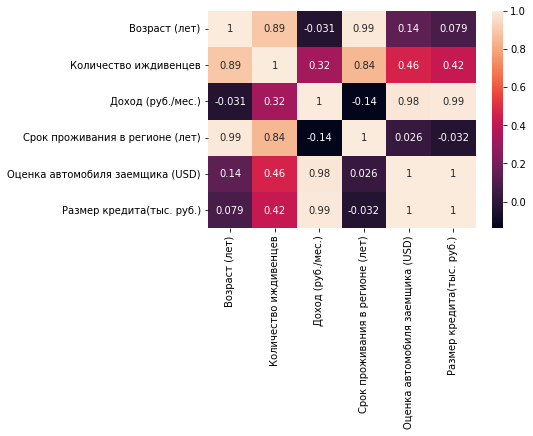

In [16]:
sns.heatmap(corrZ,annot=True)

<AxesSubplot:>

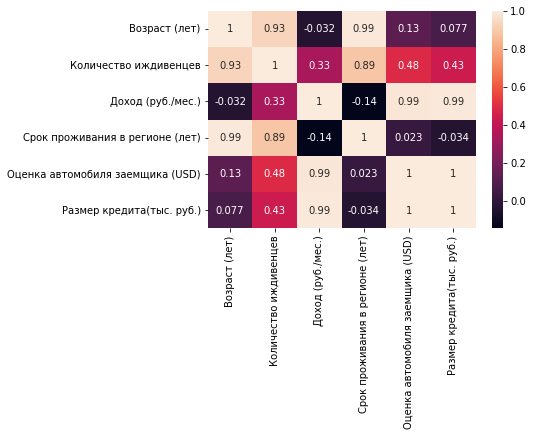

In [17]:
sns.heatmap(corrZk,annot=True)

Оценим качество аппроксимации с использованием нормы Фробениуса. Относительная погрешность для матриц корреляции приблизительно равна 2%

In [21]:
round(np.linalg.norm(corrZ-corrZk, 'fro')/np.linalg.norm(corrZ, 'fro')*100, 2)

2.17

Используя выделенные главные факторы, найдем представления клиентов векторами размерности 2 с помощью матрицы U и сохраним в переменной new_clients_representation:

In [22]:
new_clients_representation = U[:,:2]
print(new_clients_representation.shape)
print(new_clients_representation)

(50, 2)
[[-0.18706004 -0.05517949]
 [ 0.20235528  0.04210105]
 [-0.10403531  0.10733984]
 [ 0.08852962  0.09597626]
 [-0.17417087  0.02844977]
 [-0.11694484  0.16961215]
 [-0.11811486 -0.21881474]
 [ 0.08345708  0.14315429]
 [ 0.19334347  0.03482972]
 [ 0.05512871  0.06859673]
 [ 0.0996781   0.10506686]
 [ 0.18128116  0.19344052]
 [-0.09951329 -0.0792021 ]
 [ 0.10502697  0.16076498]
 [ 0.18257914 -0.19933648]
 [-0.01916207  0.01644608]
 [ 0.03025061 -0.13328661]
 [ 0.18299742 -0.22863748]
 [ 0.2376135   0.04905218]
 [ 0.23452661  0.07670123]
 [-0.22691703  0.2385085 ]
 [ 0.18636905  0.05907163]
 [-0.26911407  0.03821178]
 [-0.10769824  0.15576663]
 [ 0.05181723  0.04441185]
 [ 0.0098847  -0.04144857]
 [ 0.02438582  0.09531724]
 [ 0.12555407  0.01732441]
 [-0.19151523  0.17467311]
 [-0.02648104  0.20043664]
 [-0.18074583 -0.23011836]
 [ 0.07007753  0.18368537]
 [ 0.15528666 -0.19997977]
 [-0.14237325  0.13571548]
 [ 0.00953674  0.17842589]
 [-0.17196211 -0.0645903 ]
 [-0.10464248 -0.148

Карта клиентов будет выглядеть следующим образом:

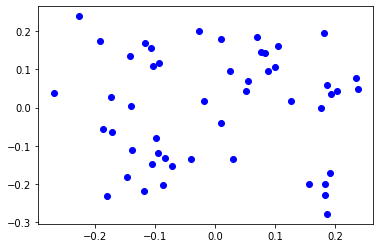

In [23]:
plt.plot(new_clients_representation[:,0], new_clients_representation[:,1],'bo')

## Интерпретация скрытых факторов

Найдем матрицу коэффициентов разложения признаков zj по главным факторам.

Получим первичную матрицу нагрузок (до вращений)

In [24]:
#SVT получена ранее как np.dot(np.diag(S[:2]), VT[:2])
SVT.T

array([[ 0.57070095, -0.81480509],
       [ 0.81413655, -0.54425426],
       [ 0.79996724,  0.59927575],
       [ 0.47662369, -0.87293252],
       [ 0.88742117,  0.45859056],
       [ 0.86027853,  0.50890925]])

Ясной картины первичные нагрузки не дают, поэтому требуется вращение. По имеющейся матрице можно предположить, что с первым главным фактором связаны признаки 2 (Количество иждивенцев), 3 (Доход (руб./мес.)), 5 (Оценка автомобиля заемщика (USD)), 6 (Размер кредита(тыс. руб.)). Со вторым, соответственно, 1 (Возраст (лет)) и 4 (Срок проживания в регионе (лет)).

Попробуем три способа вращения:
1. простой поворот на 45 градусов
2. варимакс
3. квартимакс

In [25]:
simple_mtx = [[0.71, -0.71], [0.71, 0.71]] # 45 градусов по часовой
G = np.array(simple_mtx)
simple_loadings = np.dot(G.T, SVT)
simple_loadings.T

array([[-0.17331394, -0.98370929],
       [ 0.19161643, -0.96445747],
       [ 0.99346252, -0.14249096],
       [-0.28137927, -0.95818491],
       [ 0.95566833, -0.30446974],
       [ 0.97212333, -0.24947219]])

После простого поворота корреляции стали значительно понятнее. 
* от первого фактора: 3, 5, 6
* от второго фактора: 1, 2, 4

In [26]:
#! pip install factor_analyzer
from factor_analyzer import Rotator

После применения метода варимакс получаем недостаточно четкие результаты по 6 признаку, в остальном - совпадает с простым поворотом на 45 градусов.

In [27]:
loadings = pd.DataFrame(SVT.T)
varirot = Rotator(method='varimax')
varimax_loadings = varirot.fit_transform(loadings)
varimax_mtx = varirot.rotation_
varimax_loadings

array([[ 3.40243576e-04, -9.94789822e-01],
       [ 3.54915907e-01, -9.12724340e-01],
       [ 9.99018708e-01,  3.22588524e-02],
       [-1.10065150e-01, -9.88466991e-01],
       [ 9.89996713e-01, -1.33147067e-01],
       [ 9.96612829e-01, -7.63586776e-02]])

Квартимакс дает самые однозначные результаты:
* от первого фактора:
    * 3 (Доход (руб./мес.)) 
    * 5 (Оценка автомобиля заемщика (USD))
    * 6 (Размер кредита(тыс. руб.))
* от второго фактора: 
    * 1 (Возраст (лет))
    * 2 (Количество иждивенцев)
    * 4 (Срок проживания в регионе (лет))

In [29]:
quartirot = Rotator(method='quartimax')
quartimax_loadings = quartirot.fit_transform(loadings)
quartimax_mtx = quartirot.rotation_
quartimax_loadings

array([[ 0.00987027, -0.99474091],
       [ 0.36364348, -0.90928238],
       [ 0.99866383,  0.04182793],
       [-0.10059063, -0.98947605],
       [ 0.99122683, -0.12365683],
       [ 0.99729861, -0.06680767]])

Так как нам удалось улучшить структуру матрицы нагрузок, обновим представление клиентов и построим карту.

In [30]:
Zk2 = np.dot(np.dot(U.T[:2].T, quartimax_mtx.T), quartimax_loadings.T)

In [32]:
rotated_pc = np.dot(U.T[:2].T, quartimax_mtx.T) 
# представление клиентов с поворотом

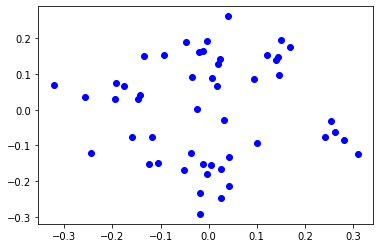

In [33]:
plt.plot(rotated_pc.T[0], rotated_pc.T[1],'bo')